# Exam Preparation: Vasicek

## Setup

In [22]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

## Plotting ZCB Prices, Spot and Forward Rates

We use the information provided in the text to assign values to the parameter: 

In [23]:
# Vasicek model parameters
r0 = 0.02 # initial interest rate
a = 0.6 # rate of reversion
b = 0.03 # parameter to be used for long run mean
sigma = 0.02 # volatility parameter scaling the diffusion term

# compute array of time to maturities for T={0.0,0.5,...,10}
T_max = 10 
alpha = 0.5
M = int(T_max/alpha)+1
T = np.array([i*alpha for i in range(M)])

Using that Vasicek possess an Affine term structure:

In [24]:
p = fid.zcb_price_vasicek(r0,a,b,sigma,T)
R = fid.spot_rate_vasicek(r0,a,b,sigma,T)
f = fid.forward_rate_vasicek(r0,a,b,sigma,T)
#f_6m = fid.zcb_to_forward_rates(T,p,horizon=1) # 6M since we have semiannual data

Make a plot:

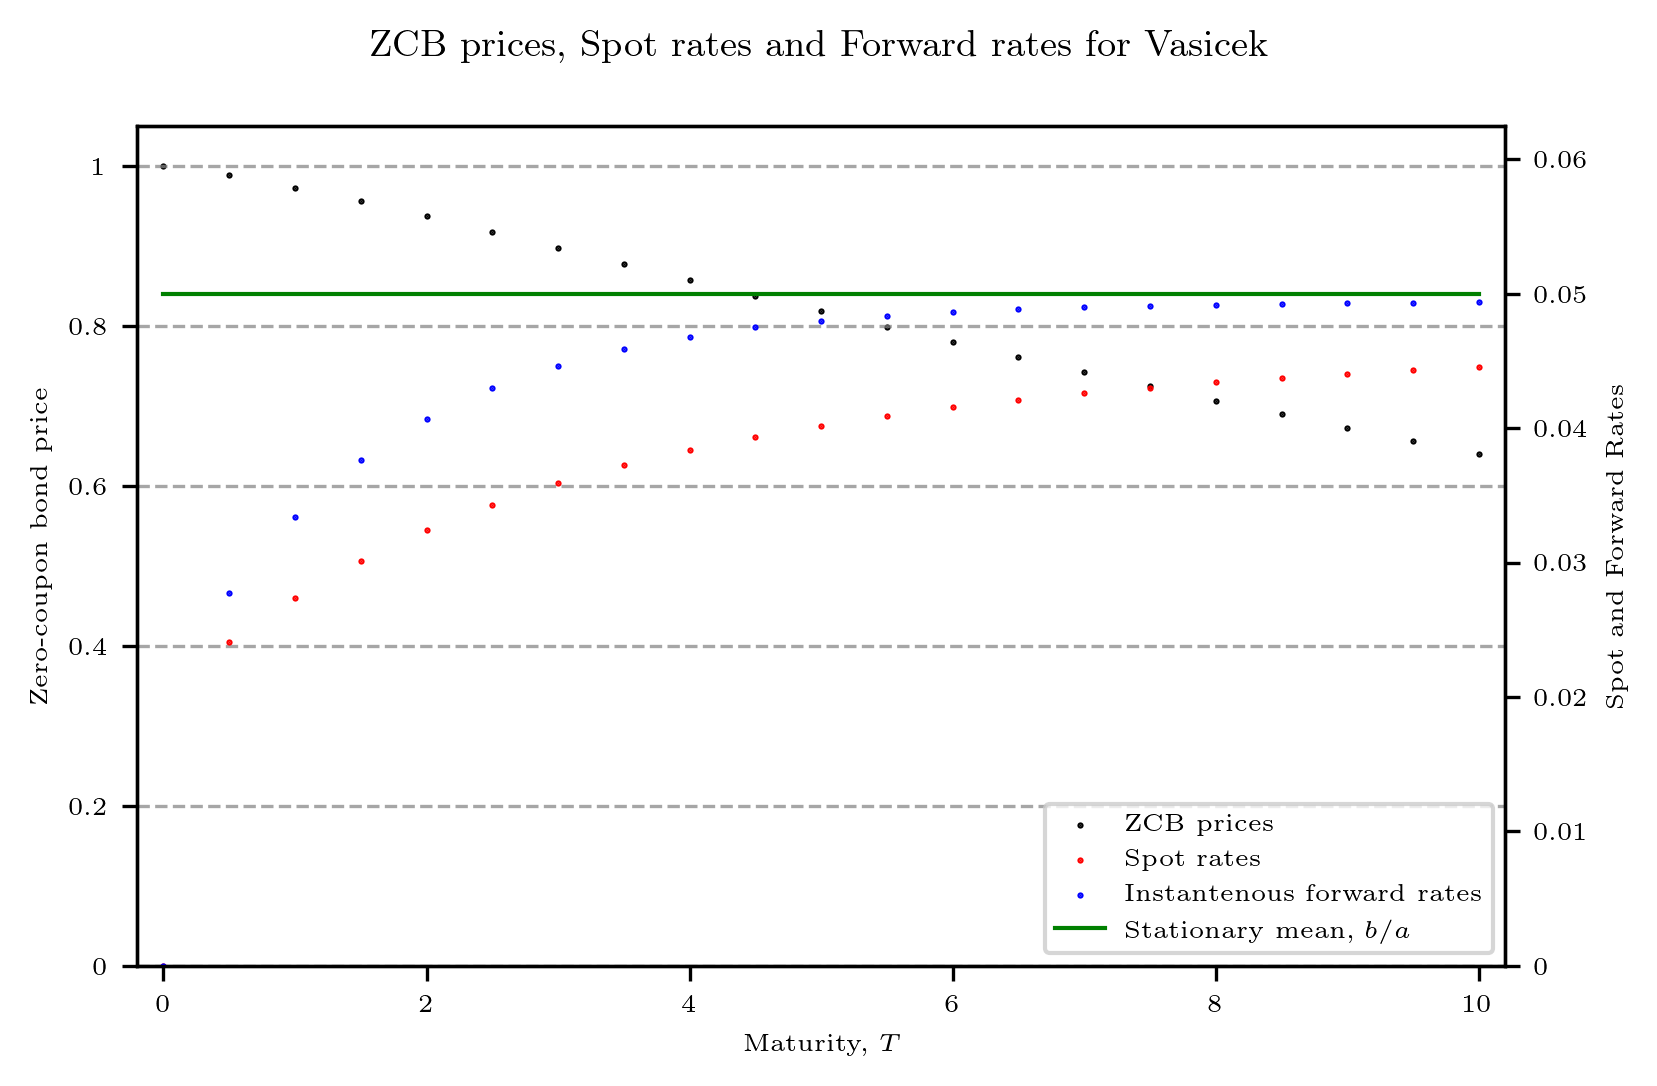

In [4]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"ZCB prices, Spot rates and Forward rates for Vasicek", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $T$",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(T, p, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.0625])
p2 = ax1.scatter(T, R, s = 1, color = 'red', marker = ".",label="Spot rates")
p3 = ax1.scatter(T, f, s = 1, color = 'blue', marker = ".",label="Instantenous forward rates")
p4 = ax1.plot(T, (b/a)*np.ones([M]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b/a$")

plots = [p1,p2,p3,p4[0]]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* ZCB prices decay
* Term structure of spot rates is upward sloping 
* Current rate of spot rate is below the stationary mean.
* Term structure of Forward rates is typically a bit further ahead.

## Fitting the Model 

**Fitting, not knowing $\sigma$**

Using the parameters given above we fit all the parameters in a Vasicek model to the spot rates. 
The purpose is to check if we are able to recover the parameters of the Vasicek model.

In [5]:
# set initial parameters (guess)
param_0 = 0.03, 0.4, 0.05, 0.04

# run optimizer
result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True}) # note, you might need to change tolerance if too many function evaluations


# store results
r0_hat, a_hat, b_hat, sigma_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x[3], result.x

# print results
print(f"The fitted parameter values are: r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}, sigma_hat: {sigma_hat:.6f}")
print(f'SSE of the fit {result.fun:.12f}') # not surprisingly, it depends on xatol!

The fitted parameter values are: r0_hat: 0.019993, a_hat: 0.598660, b_hat: 0.029998, sigma_hat: 0.021750
SSE of the fit 0.000000000009


/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_74674/301862123.py:5: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True}) # note, you might need to change tolerance if too many function evaluations


Fitting the Vasicek model to spot rates with the objective of recovering all four parameters, we discover that $\sigma$ is difficult to recover implying that $\sigma$ is not well-specified in this model. Despite our inability to recover $\sigma$, we are nonetheless able to recover the remaining parameters $r_0, a$ and $b$ quite well.

**Comparing the Empirical and Fitted Spot Rates (and Prices)**

In [6]:
# compute empirically fitted ZCB prices
p_fit = fid.zcb_price_vasicek(r0_hat,a_hat,b_hat,sigma_hat,T)
# compute empirically fitted spot rates
R_star = fid.zcb_to_spot_rates(T,p)
R_fit = fid.zcb_to_spot_rates(T,p_fit)

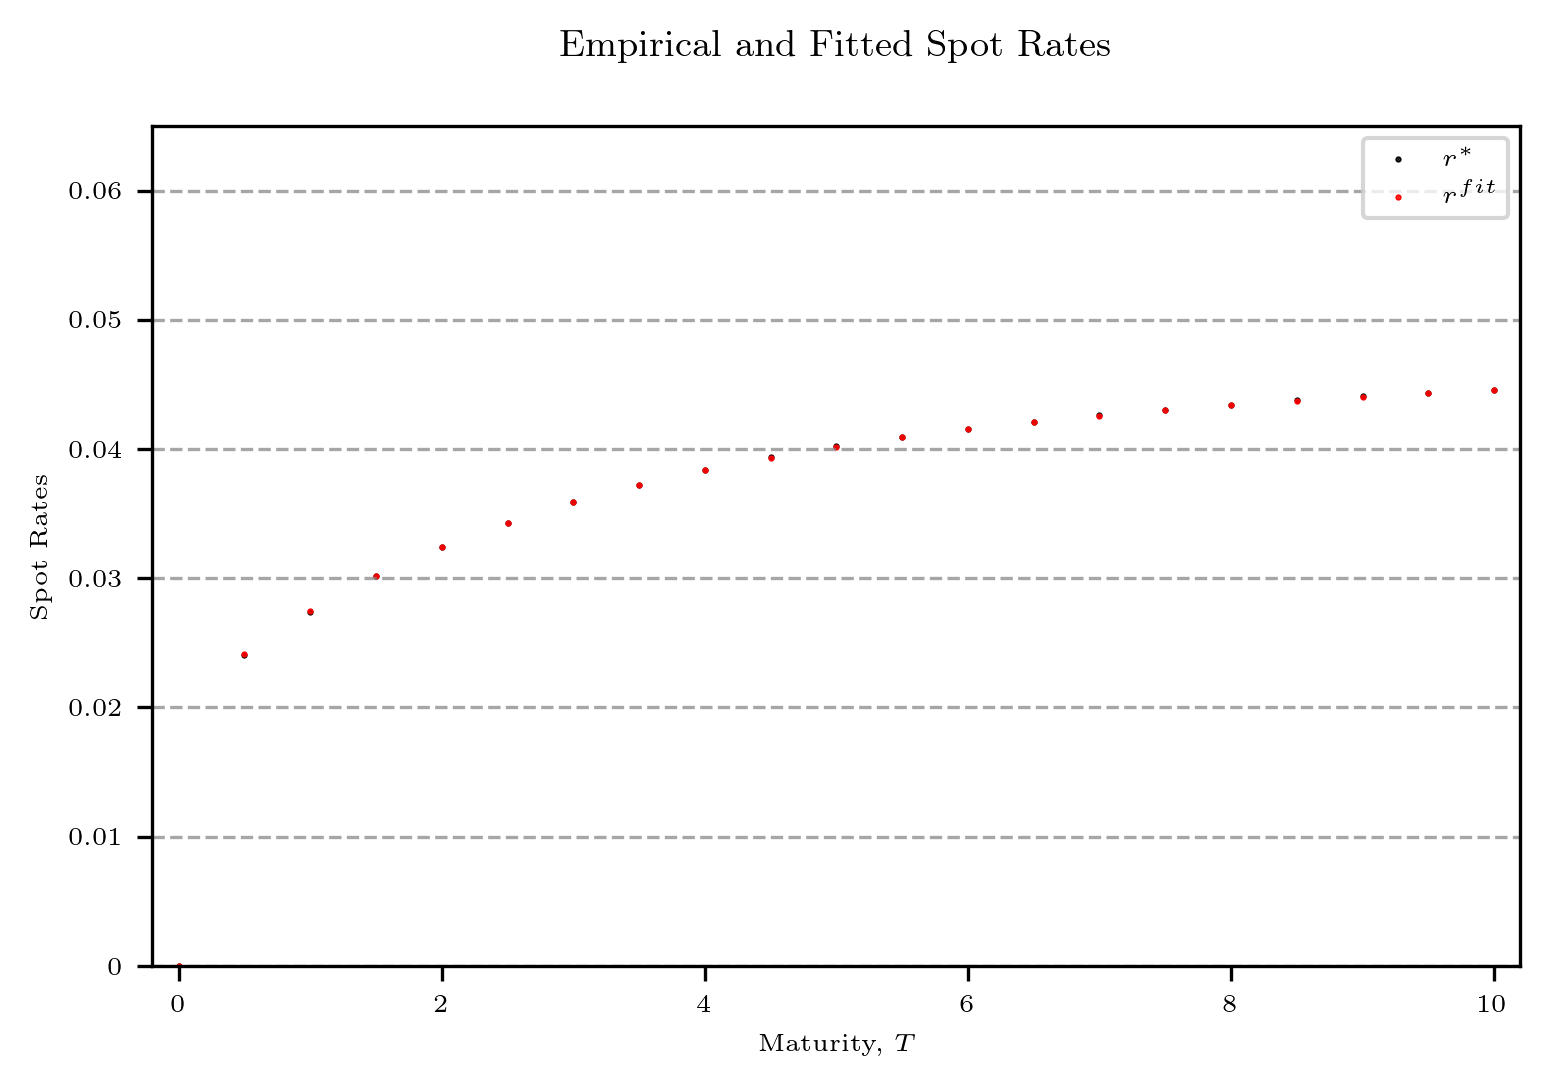

In [7]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Empirical and Fitted Spot Rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $T$",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.065])
ax.set_ylabel(f"Spot Rates",fontsize = 6)
p1 = ax.scatter(T, R, s = 1, color = 'black', marker = ".",label="$r^*$")
p2 = ax.scatter(T, R_fit, s = 1, color = 'red', marker = ".",label="$r^{fit}$")

plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

They are smack on top.

**Fitting, knowing $\sigma$**

We do not recover sigma well. So suppose instead we know that sigma is some value. So we remove sigma from param and just put it as an input like "R" and "T".

In [8]:
# set initial parameters (guess)
param_0 = 0.03, 0.4, 0.05
# run optimizer
result = minimize(fid.fit_vasicek_no_sigma_obj,param_0,method= "nelder-mead",args=(sigma, R,T), options={'xatol': 1e-12, 'disp': True})

# store results
r0_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x

# print results
print(f"The fitted parameter values are: r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}")
print(f'SSE of the fit {result.fun:.12f}') # not surprisingly, it depends on xatol!

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 199
         Function evaluations: 370
The fitted parameter values are: r0_hat: 0.020000, a_hat: 0.600000, b_hat: 0.030000
SSE of the fit 0.000000000000


If we fit the Vasicek model to spot rates assuming that $\sigma=0.02$ is known the algorithm will converge very fast and the remaining parameters be returned with high accuracy illustrating once again that $r_0, a$ and $b$ are very will identified in the model.

### Constrained Optimization

In the previous, you have performed an unconstrained optimization in the sense that none of the parameters have been restricted to take values in a certain range. Next, we will investigate how to impose, bounds and constraints on the optimization and we will once again optimize over all four parameters $r, a, b, \sigma$.

In [9]:
from scipy.optimize import Bounds, NonlinearConstraint

**A)** Imposing bounds: $0 \leq r \leq 0.1,0 
\leq a \leq 10,0 \leq b \leq 0.2$ and $0 \leq \sigma \leq 0.1$

In [10]:
def fit_vasicek_obj(param,p_star,T):
    """ SSE for fitted ZCB prices against 'market' data. """
    r0, a, b, sigma = param
    N = len(p_star)
    p_fit = fid.zcb_price_vasicek(r0,a,b,sigma,T)
    y = 0
    for i in range(0,N):
        y += 1e16*(p_fit[i] - p_star[i])**2
    return y

In [11]:
# set initial parameters (guess)
param_0 = (0.03, 1.8, 0.12, 0.03)

# define bounds
bounds = Bounds([0.,0,0,0],[0.1,10,0.2,0.1])

# run constrained optimizer
result = minimize(fit_vasicek_obj,param_0,method = 'trust-constr',bounds = bounds,args = (p,T),options={'disp': True})
r0_hat, a_hat, b_hat, sigma_hat, SSE = result.x[0], result.x[1], result.x[2], result.x[3], result.fun
print(f"r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}, and sigma_hat: {sigma_hat:.6f}")

/Users/hanschristian/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 231, function evaluations: 1340, CG iterations: 541, optimality: 3.43e+08, constraint violation: 0.00e+00, execution time:  0.6 s.
r0_hat: 0.020172, a_hat: 0.599762, b_hat: 0.029656, and sigma_hat: 0.000000


In [12]:
# compute empirically fitted ZCB prices
p_fit = fid.zcb_price_vasicek(r0_hat,a_hat,b_hat,sigma_hat,T)
# compute empirically fitted spot rates
R_star = fid.zcb_to_spot_rates(T,p)
R_fit = fid.zcb_to_spot_rates(T,p_fit)

**B)** Imposing bounds: $0 \leq r \leq 0.1,0 \leq a \leq 1.8, 0\leq b \leq 0.08$ and $0 \leq \sigma \leq 0.1$

In [13]:
# set initial parameters (guess)
param_0 = (0.03, 1.8, 0.12, 0.03) # random

# define bounds
bounds = Bounds([0.,0,0,0],[0.1,1.8,0.08,0.1])

# run constrained optimizer
result = minimize(fit_vasicek_obj,param_0,method = 'trust-constr',bounds = bounds,args = (p,T),options={'xtol': 1e-20, 'disp': True})
r0_hat, a_hat, b_hat, sigma_hat, SSE = result.x[0], result.x[1], result.x[2], result.x[3], result.fun
print(f"r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}, and sigma_hat: {sigma_hat:.6f}")

`xtol` termination condition is satisfied.
Number of iterations: 458, function evaluations: 2190, CG iterations: 693, optimality: 8.35e+06, constraint violation: 0.00e+00, execution time: 0.79 s.
r0_hat: 0.000000, a_hat: 1.354574, b_hat: 0.064664, and sigma_hat: 0.000000


In [14]:
# compute empirically fitted ZCB prices
p_fit = fid.zcb_price_vasicek(r0_hat,a_hat,b_hat,sigma_hat,T)
# compute empirically fitted spot rates
R_star = fid.zcb_to_spot_rates(T,p)
R_fit = fid.zcb_to_spot_rates(T,p_fit)

Now we get a much worse fit. 

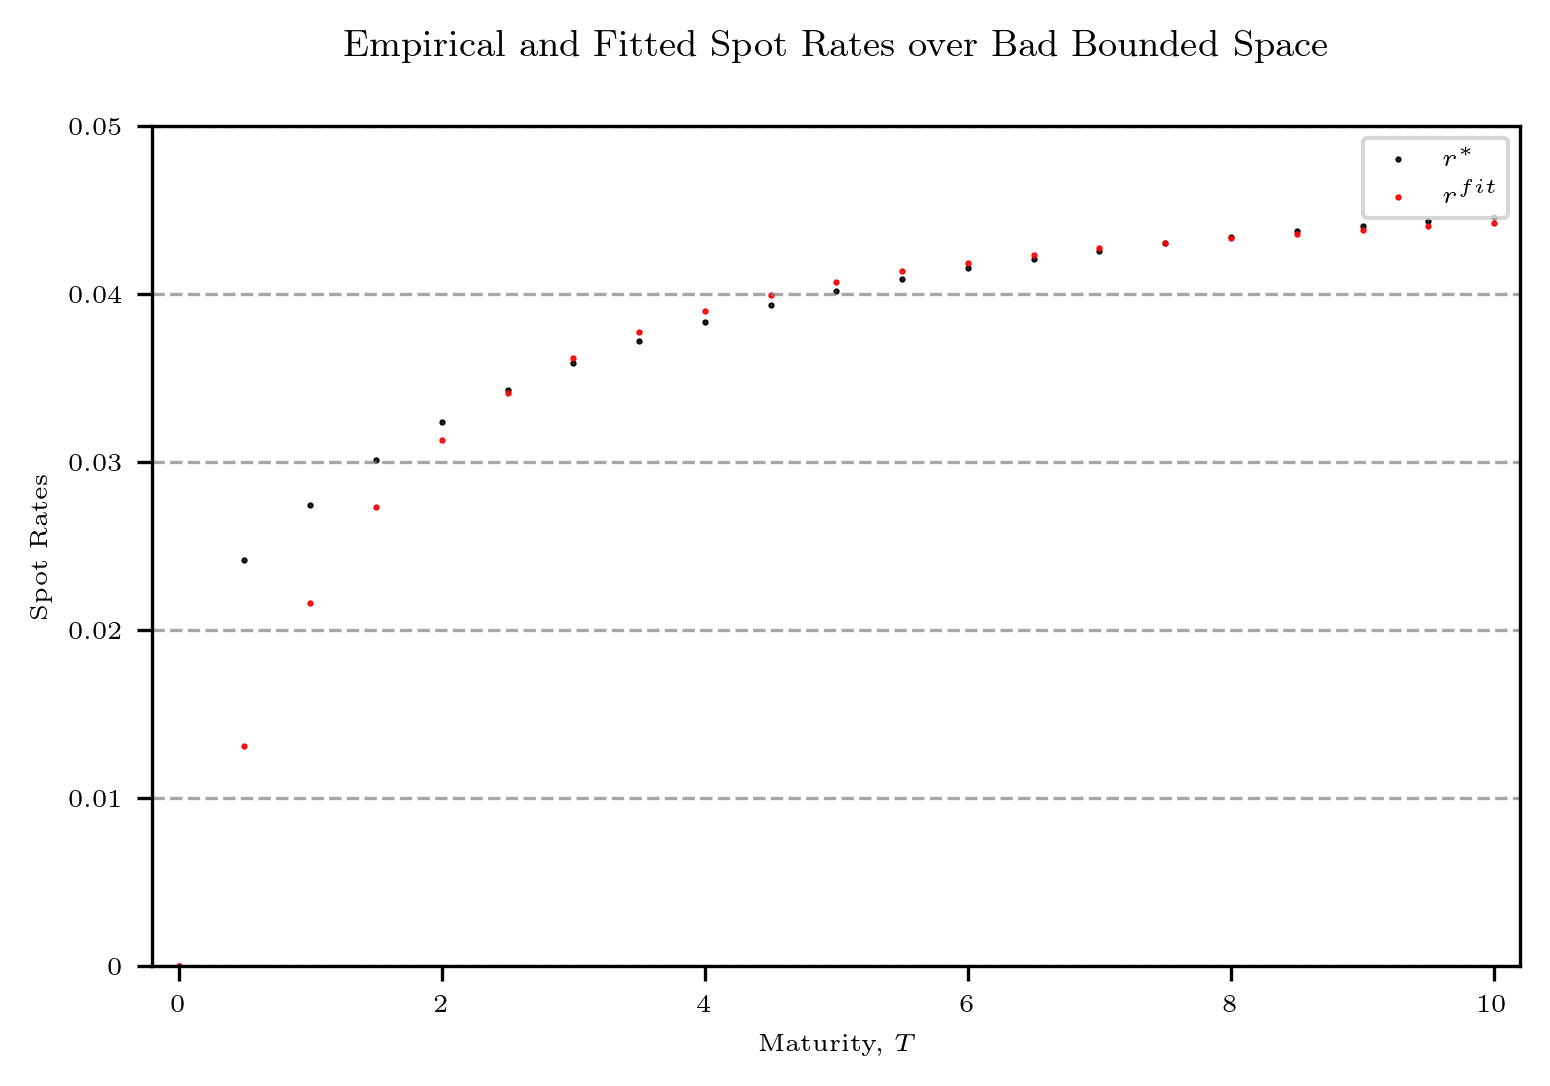

In [15]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Empirical and Fitted Spot Rates over Bad Bounded Space", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $T$",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.05])
ax.set_ylabel(f"Spot Rates",fontsize = 6)
p1 = ax.scatter(T, R_star, s = 1, color = 'black', marker = ".",label="$r^*$")
p2 = ax.scatter(T, R_fit, s = 1, color = 'red', marker = ".",label="$r^{fit}$")
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)


plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

**C)** Imposing bounds + Adding non-linear constraints: 
$$0 \leq r \leq 0.1,0 
\leq a \leq 10,0 \leq b \leq 0.2$ and $0 \leq \sigma \leq 0.1$$
$$2 a b \geq \sigma^2$$

Auxiliary functions:

In [16]:
def cons_f(param):
    return [2*param[1]*param[2] - param[3]**2]

def cons_J(param):
    """ Jacobian."""
    return [[0,2*param[2],2*param[1],-2*param[3]]]

def cons_H(param,v):
    """ Hessian."""
    return v[0]*np.array([[0,0,0,0],[0,0,2,0],[0,2,0,0],[0,0,0,-2]])

In [17]:
# set initial parameters (guess)
param_0 = (0.03, 1.8, 0.12, 0.03) 

# define bounds
bounds = Bounds([0.,0,0,0],[0.1,10,0.2,0.1])

# define nonlinear constraints
nonlinear_constraint = NonlinearConstraint(cons_f, 0, np.inf, jac=cons_J, hess=cons_H)

# run constrained optimizer
result = minimize(fit_vasicek_obj,param_0,method = 'trust-constr',args = (p,T),bounds = bounds,constraints=[nonlinear_constraint],options={'disp': True})
r0_hat, a_hat, b_hat, sigma_hat, SSE = result.x[0], result.x[1], result.x[2], result.x[3], result.fun
print(f"r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}, sigma_hat: {sigma_hat:.6f}")
print(f"r0: {r0:.6f}, a: {a:.6f}, b: {b:.6f}, sigma: {sigma:.6f}")

`xtol` termination condition is satisfied.
Number of iterations: 248, function evaluations: 2165, CG iterations: 609, optimality: 7.84e+07, constraint violation: 0.00e+00, execution time: 0.56 s.
r0_hat: 0.020176, a_hat: 0.599604, b_hat: 0.029648, sigma_hat: 0.000000
r0: 0.020000, a: 0.600000, b: 0.030000, sigma: 0.020000


In [18]:
# compute empirically fitted ZCB prices
p_fit = fid.zcb_price_vasicek(r0_hat,a_hat,b_hat,sigma_hat,T)
# compute empirically fitted spot rates
R_star = fid.zcb_to_spot_rates(T,p)
R_fit = fid.zcb_to_spot_rates(T,p_fit)

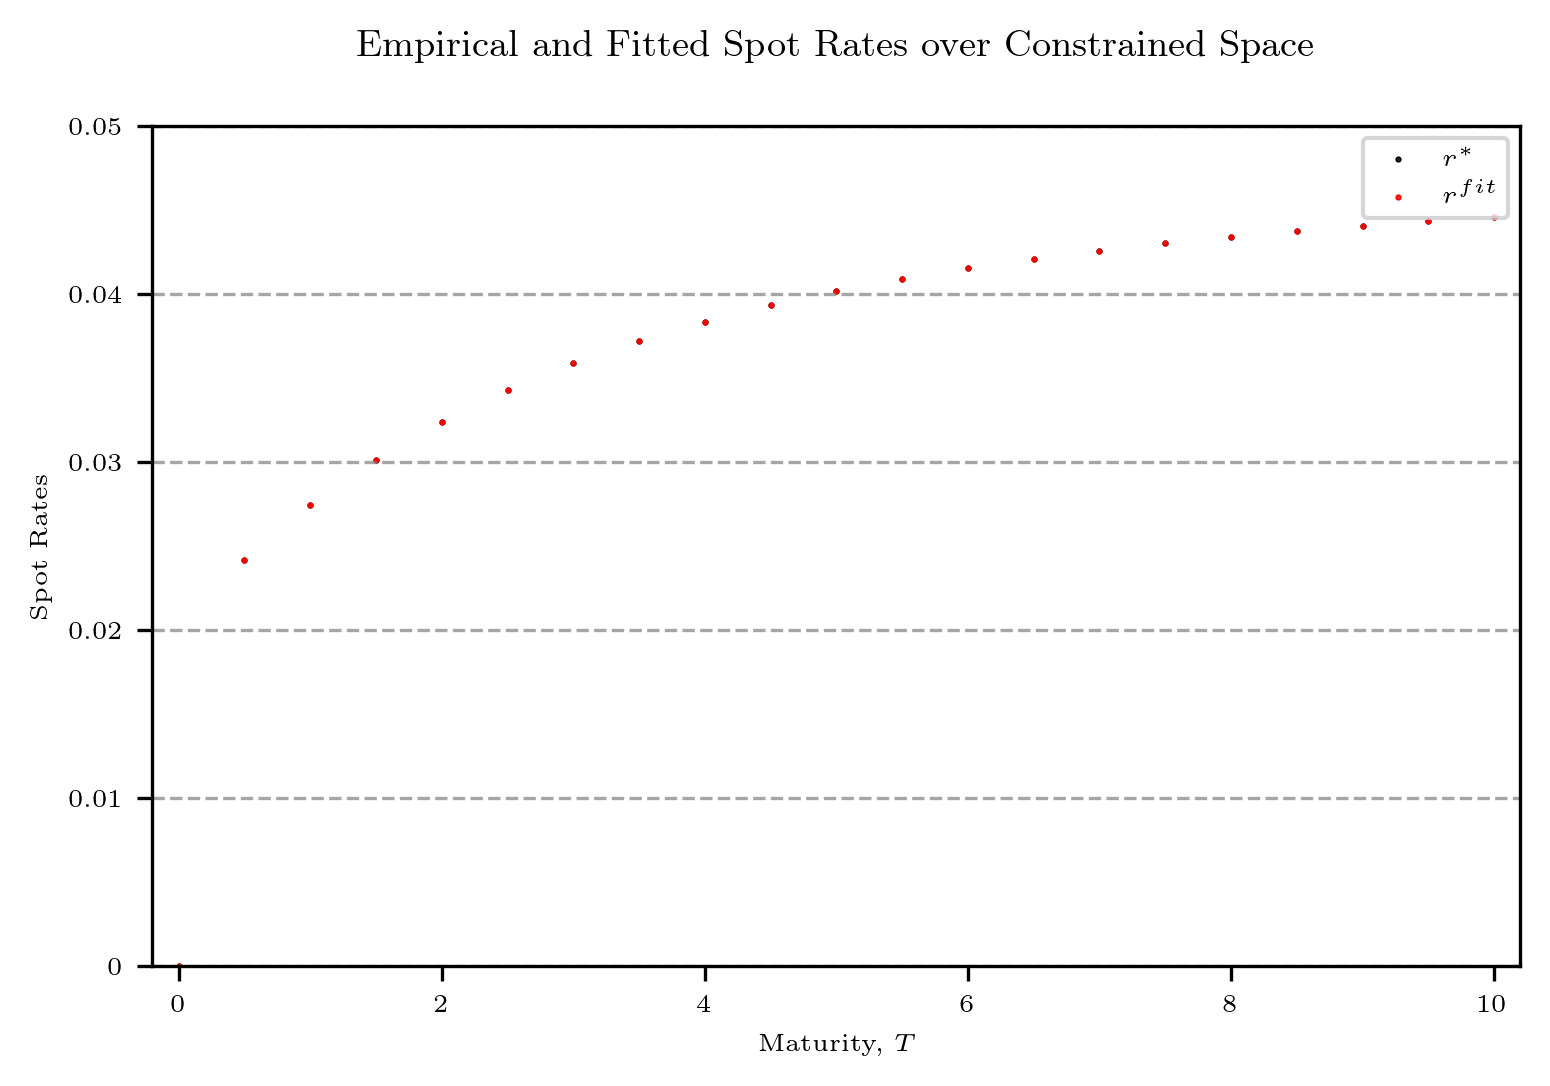

In [19]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Empirical and Fitted Spot Rates over Constrained Space", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $T$",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.05])
ax.set_ylabel(f"Spot Rates",fontsize = 6)
p1 = ax.scatter(T, R_star, s = 1, color = 'black', marker = ".",label="$r^*$")
p2 = ax.scatter(T, R_fit, s = 1, color = 'red', marker = ".",label="$r^{fit}$")
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)

plt.show()

## Simulating

We simulate the dynamics of the short rate in the Vasicek model
$$
\begin{aligned}
d r_t & =\left(b-a r_t\right) d t+\sigma d W_t, \quad t>0 \\
r(0) & =r_0
\end{aligned}
$$
on a grid of mesh $\delta$ that runs from initial time $t_0=0$ to some terminal time $T$. Denote by $\mathrm{N}$, the number of steps in your simulation. The time points in your simulation will be numbered $n=0,1,2, \ldots, N-1, N$ and the time points will be $\left[t_0, t_1, \ldots, t_{N-1}, t_N\right]=[0, \delta, 2 \delta, \ldots, T-\delta, T]$ and equidistant time steps $\delta=\frac{T}{N}$. The scheme you will need to implement is a simple Euler first-order scheme of the form

$$
r_n=r_{n-1}+\left(b-a r_{n-1}\right) \delta+\sigma \sqrt{\delta} Z_n, \quad n=1,2, \ldots, N
$$
where $Z_n \sim N(0,1), n=1, \ldots, N$ and all the standard normal random variables are independent.

### Simulating One Trajectory

In [20]:
np.random.seed(13) # set seed
M_simul, T_simul = 1_000, 10 # time steps, maturity
size_ci = 0.95 # confidence interval
r_simul = fid.short_rate_simul(r0,(a,b,sigma),M_simul,T_simul,method = "vasicek")
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])

# confidence bounds
lb, ub = fid.ci_vasicek(r0,a,b,sigma,t_simul,size_ci, method="two_sided") # lower & upper bound
mu_sd = b/a
sigma_sd = sigma/(np.sqrt(2*a))
lb_sd = mu_sd - norm.ppf(size_ci + 0.5*(1-size_ci))*sigma_sd
ub_sd = mu_sd + norm.ppf(size_ci + 0.5*(1-size_ci))*sigma_sd

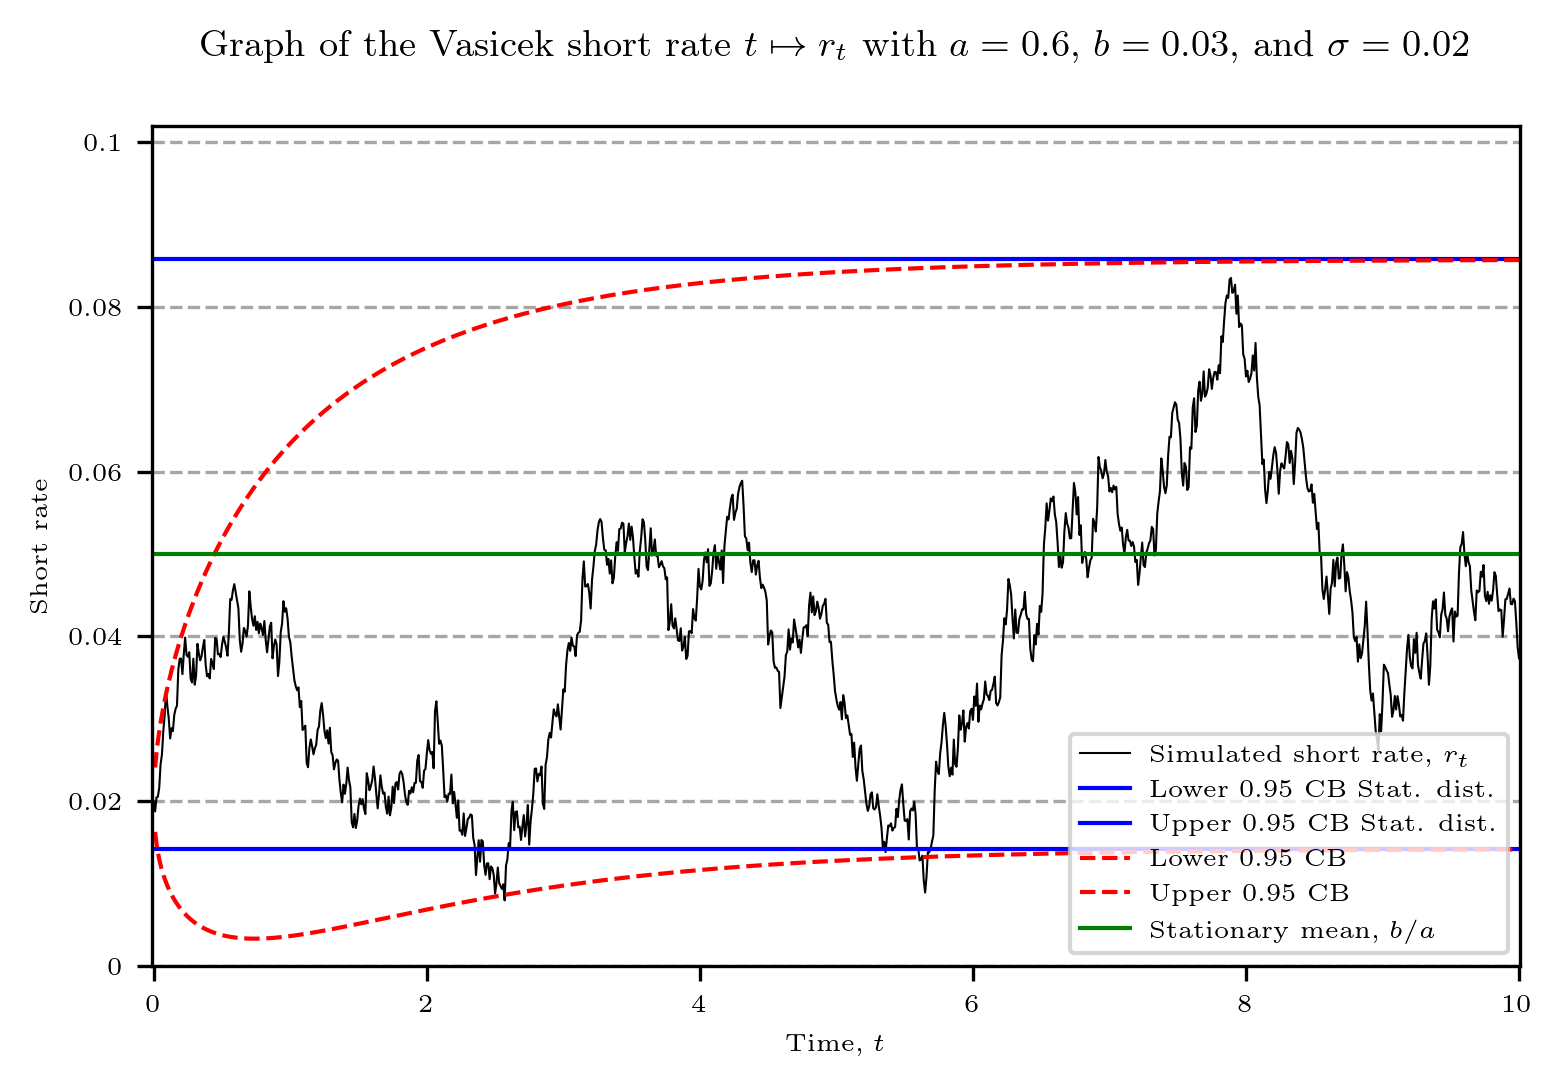

In [21]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Graph of the Vasicek short rate $t \mapsto r_t$ with $a={a}$, $b={b}$, and $\sigma={sigma}$", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time, $t$",fontsize = 6)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
ax.set_ylabel(f"Short rate",fontsize = 6)

# simulated short rate
ax.plot(t_simul, r_simul, color = 'black', marker = "", linewidth = 0.5, label = "Simulated short rate, $r_t$")

# stationary CI
ax.plot(t_simul,lb_sd*np.ones([M_simul+1]),color = 'blue',marker = "", linewidth = 1, label = f"Lower {size_ci} CB Stat. dist.")
ax.plot(t_simul,ub_sd*np.ones([M_simul+1]),color = 'blue',marker = "", linewidth = 1, label = f"Upper {size_ci} CB Stat. dist.")

# simulated CI
ax.plot(t_simul, lb, color = 'red', marker = "", linewidth = 1, linestyle = "dashed", label =f"Lower {size_ci} CB")
ax.plot(t_simul, ub, color = 'red', marker = "", linewidth = 1, linestyle = "dashed", label = f"Upper {size_ci} CB")

# stationary mean
ax.plot(t_simul, mu_sd*np.ones([M_simul+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b/a$")

ax.legend(loc = "lower right",fontsize = 6)

plt.savefig('figureX.pdf', format='pdf')

One simulated trajectory of the short rate can be seen in the plot.

* The Vasicek model may become negative due to its Gaussian distribution. Although real interest rates may sometimes fall below zero, this can be regarded as a potential drawback of the Vasicek model. The next code provides a numerical solution of the stochastic different. 
* Confidencen bounds should narrow as it comes closer to the bounds of the statioanry distribution.

The value $r_5$ in the simulation is of course the short three years after the initial point, and since the confidence interval of $r_5$ is different from that of the stationary distribution, we can conclude that 3 years is not enough time for the short rate to settle to its stationary distribution. Convergence to the stationary distribution will be faster if either $a$ is large or $\sigma$ is small.

## Swap Rates

We consider interest rate swaps that involve swapping $6 \mathrm{M}$ floating rate payments (EURIBOR say) paid semiannually for fixed payments also paid semi-annually. 
- present time is $t=0$ 
- $6 \mathrm{M}$ floating rate to be paid at time $T=0.5$ has just been announced. 
- notional of these swaps is just 1.

We know the first half-year, so we don't have to take into account that some time of the initial LIBOR rate has already past.
$$
R_{\text {swap }}(t=0)=\frac{P(0,0)-p(0, N)}{S_{\text {swap }}}
$$

Where the denominator is the accrual factor which comes from the fixed leg: $\sum_{i=1}^N \alpha_i p\left(t, T_i\right)$ where $\alpha$ is tenor. The floating leg was simply since we could compute it as a telescoping sum.

Computing par swap rate (**remember to rerun begin of code**)

In [25]:
# 10Y swap pricector
idx_n, idx_N = 0, 20 # first and last fixing where 20/2 = 10Y
S_swap = fid.zcb_to_accrual_factor(T[idx_n],T[idx_N],'semiannual',T,p)
R_swap = fid.zcb_to_par_swap_rate(T[idx_n],T[idx_N],'semiannual',T,p)
print(f'R_swap is {R_swap}')

R_swap is 0.04431567559300563


**Alternatively**

In [26]:
# 10 Y swap price
#idx_n, idx_N = 0, 20 # first and last fixing where 20/2 = 10Y
#S_swap = 0 
#for idx in range(idx_n+1,idx_N+1): # already added 1 to M, hence no need for M+1 here, so M is included!
#    S_swap += 0.5*p[idx]

#R_swap = (p[idx_n]-p[idx_N])/S_swap
#print(f'R_swap is {R_swap}')

**New we have to do it for all maturities and not just for 10Y**

In [27]:
# Plotting the spot par swap rate
def swap_fct(idx_n,idx_N,alpha,p):
    S_swap = 0
    for idx in range(idx_n+1,idx_N+1):
        S_swap += alpha*p[idx]
    R_swap = (p[idx_n] - p[idx_N])/S_swap
    return R_swap, S_swap

R_swap_plot = np.zeros([M])
S_swap_plot = np.zeros([M])
idx_N_plot = np.array([i for i in range(1,M)])
for idx in idx_N_plot:
    R_swap_plot[idx], S_swap_plot[idx] = swap_fct(0,idx,alpha,p)[0], swap_fct(0,idx,alpha,p)[1]

In [28]:
print(R_swap_plot)
print(S_swap_plot)

[0.         0.02429662 0.02759428 0.0303097  0.03255601 0.0344238
 0.03598539 0.03729853 0.0384093  0.03935455 0.04016383 0.04086087
 0.0414648  0.04199109 0.04245231 0.04285872 0.0432187  0.04353915
 0.04382577 0.0440833  0.04431568]
[0.         0.49399875 0.98047106 1.45836968 1.92700193 2.38593545
 2.83492746 3.27387215 3.70276191 4.12165889 4.53067426 4.92995317
 5.31966378 5.6999894  6.07112279 6.43326211 6.78660793 7.13136125
 7.46772191 7.79588769 8.11605349]


Duration can be understood as the average time it takes to receive the cash flows from an investment, thus directly linking it to the maturity of the investment. The longer the maturity
- the longer it typically takes to recoup the initial investment. 
- This concept is particularly evident in the case of a zero-coupon bond (ZCB), where the duration is exactly equal to its maturity, as all cash flows occur at maturity. 
- In our case, for maturity 10Y bond the S_Swap (accrual factor which is approx duration) is 8.11 years!

**Adding 6M Forward Rates**

In [29]:
f_6m = fid.zcb_to_forward_rates(T,p,horizon = 1) # 6M for semiannual means 1 in horizon
f_6m

array([0.        , 0.02415022, 0.03070602, 0.03556268, 0.03916058,
       0.04182597, 0.04380054, 0.04526334, 0.046347  , 0.0471498 ,
       0.04774453, 0.04818512, 0.04851151, 0.04875331, 0.04893244,
       0.04906514, 0.04916345, 0.04923628, 0.04929023, 0.0493302 ,
       0.04935981])

**Plotting**

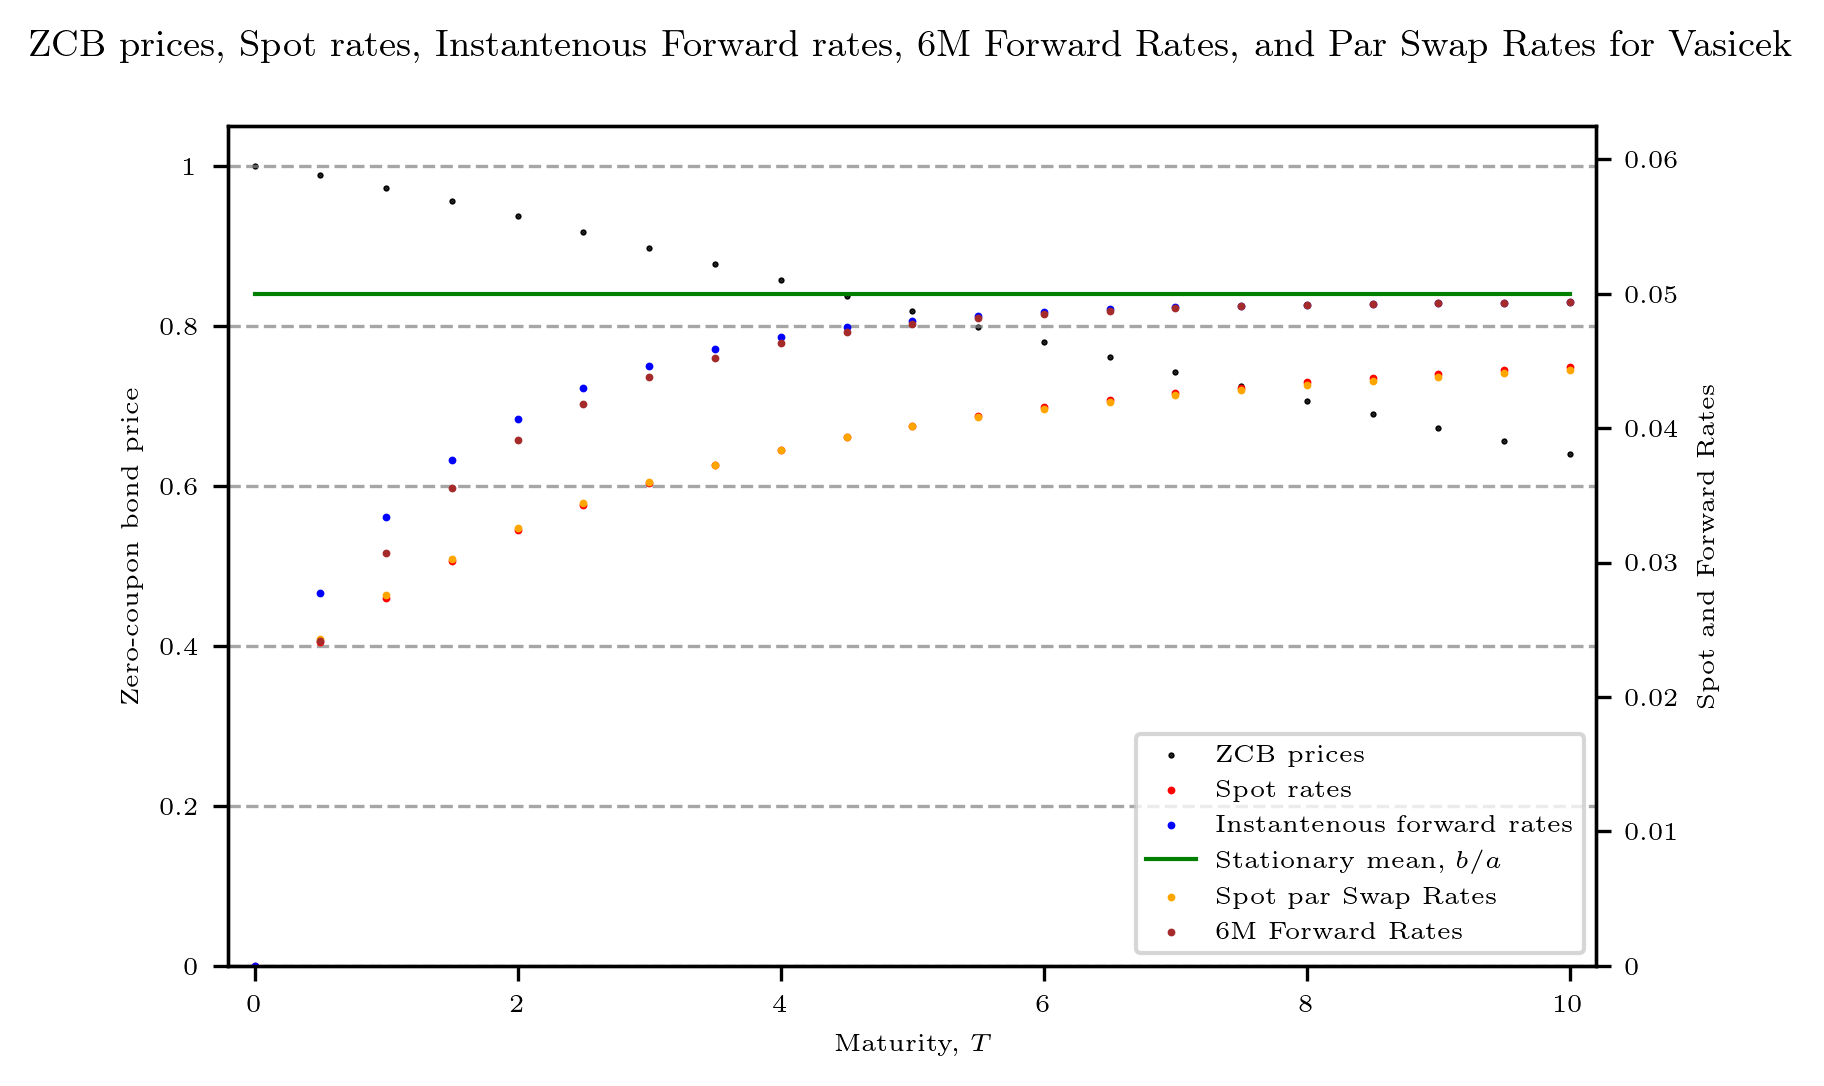

In [30]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"ZCB prices, Spot rates, Instantenous Forward rates, 6M Forward Rates, and Par Swap Rates for Vasicek", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $T$",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(T, p, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.0625])
p2 = ax1.scatter(T, R, s = 3, color = 'red', marker = ".",label="Spot rates")
p3 = ax1.scatter(T, f, s = 3, color = 'blue', marker = ".",label="Instantenous forward rates")
p4 = ax1.plot(T, (b/a)*np.ones([M]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b/a$")
p5 = ax1.scatter(T[1:], R_swap_plot[1:], s = 3, color = 'orange', marker = ".",label="Spot par Swap Rates")
p6 = ax1.scatter(T[1:], f_6m[1:], s = 3, color = 'brown', marker = ".",label="6M Forward Rates")

plots = [p1,p2,p3,p4[0],p5,p6]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* We see that the par swap rates and ZCB spot rates are almost the same. 
    - The net cazh flow (fix - float) for payer swap is quite small, so the net payment until the end is relative small. 
    - Likewise, for ZCB, the payment is at the very end. 
* Remember the accrual factor of a swap is change in value of swap if par-swap rate changes by 1 bp, essentially sensitive of bond price to changes in par-swap rate. Likewise, for a regular duration is the change in value of a bond for a unit change in YTM. So you can say that accrual factor plays same role as duration for ZCB. Notice, duration of ZCB is equal to maturity.
* Alternatively, we can interpret duration as average time until you get your cash flow back, hence larger maturity the longer it takes to get investment back.Duration is a measure of when that happens. Hence why equal to maturity to ZCB. Hence duration of a bond is proportional to maturity. In our case, for maturity 10 Y bond the S_Swap (accrual factor which is approx duration) is 8.11 years!
* Par swap rates are a weighted average of the $6 \mathrm{M}$ forward rates with more weight placed on forward rates over the near future.
* Par swap rates and zero coupon bond rates are relatively close because an interest rate swap is in nature quite close to a zero coupon bond. Now, a zero coupon bond band pays no coupons and has only one cashflow at the very end. The net coupons to an interest rate swap are however are also relatively small as they consist of the difference between the fixed par swap rate and the floating rate in this case 6M EURIBOR. Furthermore, since the fixed par swap rate is a weighted average of $6 \mathrm{M}$ forward rates, the average net coupon to an interest rate swap tends to be close to 0 .

## Interest Rate Cap

A caplet is an instrument which, for a price of course, caps the interest payment on some given future floating rate payment of in this case 6M EURIBOR. An interest rate cap consists of multiple caplet and is thus a tool to cap a series of floating rate payments at some a priori chosen level. A caplet can be seen as a European call option on a future floating rate and using a simple replication argument, this European call option on the floating rate can equivalently be priced as a put option on the forward ZCB price corresponding to the forward floating rate.

Let the strike rate be $R=0.05$.

In [31]:
# define setup
strike = 0.05 # K
idx_cap_begin, idx_cap_end = 2, M # no caplet for index 0,1 so earliest begining is 2 since we already know LIBOR in period first two time periods and thus no uncertainty
price_caplet = np.zeros([M])
alpha = 0.5 # semiannual

# compute price of caplet
for i in range(idx_cap_begin, idx_cap_end):
    price_caplet[i] = (1+alpha*strike)*fid.euro_option_price_vasicek(1/(1+alpha*strike),T[i-1],T[i],p[i-1],p[i],a,sigma,type = 'put')

In [32]:
# print caplets (remember they are expressed in bps)
price_caplet*10_000

array([ 0.        ,  0.        ,  0.82344338,  4.88730147,  9.70716233,
       13.91207038, 17.19665379, 19.60388568, 21.27601462, 22.36757104,
       23.01583027, 23.33311028, 23.4074108 , 23.30590263, 23.07899061,
       22.7640539 , 22.38857386, 21.97262086, 21.53077215, 21.07356263,
       20.60856787])

Now since a cap is a sequence of caplets all of which have same strike, but different maturity we may thus compute it is the sum

In [33]:
S_swap = fid.zcb_to_accrual_factor(T[idx_n],T[idx_N],'semiannual',T,p)

# Compute price and premium of cap
price_cap = np.sum(price_caplet[idx_cap_begin:idx_cap_end])
#distributed price of caps into payments as a spread on top of floating rate in order to be insured against floating rate of 5 % (strike)
premium = alpha*(price_cap/S_swap)
print(f'Cap price: {10_000*price_cap} bps, cap premium {10_000*premium} bps') # "10_000", to turn premium into basis points

Cap price: 356.25349853776277 bps, cap premium 21.947458747693855 bps


So pays 22 basis points on top of semi annual coupon payments to be insured.

The price of the $10 \mathrm{Y}$ interest rate cap with a strike of $R=0.05$ can be found as the sum of the prices of the individual caplets and the price of the cap becomes 0.035625 or 356.25 basispoints. The price of the cap corresponds to a semi-annual premium of 21.9475 basispoints.

**Computing the dollar value of sigma changing (accurate method)** \
How sensitive is valuation of cap to changes in cap, where sigma is diffusion coefficient in Vasicek model. So we want to examine risk of choosen the wrong $\sigma$ or that tomorrow $\sigma$ has changed.

In [34]:
def price_cap_fct(sigma,strike,S_swap,idx_cap_begin,idx_cap_end,M,alpha,T,a):
    """
    Param: sigma is diffusion parameter"""
    p = fid.zcb_price_vasicek(r0,a,b,sigma,T) # added!
    price_caplet = np.zeros([M])
    for i in range(2,M):
        price_caplet[i] = (1 + alpha*strike)*fid.euro_option_price_vasicek(1/(1 + alpha*strike),T[i-1],T[i],p[i-1],p[i],a,sigma,type = "put")
    price_cap = sum(price_caplet[idx_cap_begin:idx_cap_end])
    premium = alpha*(price_cap/S_swap)
    return price_cap, premium

In [35]:
price_cap_bump, premium_bump = price_cap_fct(sigma+0.001,strike,S_swap,idx_cap_begin,idx_cap_end,M,alpha,T,a)
print(f"price_cab after bump: {price_cap_bump}, difference: {10_000*(price_cap_bump-price_cap)}")

price_cab after bump: 0.03763210620946583, difference: 20.067563556895525


**Computing the dollar value of sigma changing (not exact method)**

In this case, $\sigma$ is the diffusion coefficient in the Vasicek model. So we want to examine risk of choosen the wrong $\sigma$ or that tomorrow $\sigma$ has changed. We should get same result if modest change in $\sigma$.

***Factor Influencing caplet (and hence cap) value:***
- Volatility: Higher volatility in interest rates increases the likelihood that the caplet will be in-the-money, leading to a higher value.
    - If sigma goes up by 0.001 then the price of the caplet increases. The likelihood of libor going crazy (high volaitlity) is increased when you choose lower sigma. So in essence increasing uncertainty.
    - This means more probability mass is ITM (although also OTM) in the right hand tail. Meaning more likely to finish ITM and hence call option is more valuable (higher price).
- Time to Expiration: The longer the time to expiration, the greater the probability that the caplet will be exercised, resulting in a higher value.
    - say 10Y swap has a lot of cash flows and thus, so swap with more cash flows will tend to vary more with the parameters in the model. 
- Difference between Strike Rate and Cap Rate: A larger difference between these rates increases the likelihood of the caplet being exercised, leading to a higher value.

## Payer Swaption

We will now introduce a $2 \mathrm{Y} 8 \mathrm{Y}$ payer swaption with a strike of $K=0.045$. That is, we will introduce a swaption that gives the owner the right but not obligation to enter into a $8 \mathrm{Y}$ swap at exercise in $T_n=2$ years so that we have $T_N=10$. To compute the price of this swaption, you will need to use simulation.

**i) Argue that the payoff function $\chi\left(T_n\right)$ and the discounted payoff function $\tilde{\chi}\left(T_n\right)$ of the payer swaption are.**
$$
\begin{aligned}
& \chi\left(T_n\right)=S_n^N\left(T_n\right)\left(R_n^N\left(T_n\right)-K\right)_{+} \\
& \tilde{\chi}\left(T_n\right)=\exp \left\{-\int_0^{T_n} r_t d t\right\} S_n^N\left(T_n\right)\left(R_n^N\left(T_n\right)-K\right)_{+}
\end{aligned}
$$

We know that a $2 \mathrm{Y} 8 \mathrm{Y}$ payer swaption is a European option which gives the holder the right but not obligation to enter into a payer swap paying a fixed rate $K=0.045$ at maturity $T_n=2$, i.e. the option to enter expires at $T_n=2$.

The value of the underlying $8 \mathrm{Y}$ swap at time $T_n=2$ is $S_n^N\left(T_n\right)\left(R_n^N\left(T_n\right)-K\right)$ and if this value is positive, it will be beneficial to exercise the swaption giving us the first equation above. The second equation follows simply comes from discounting.

**II) A method to compute the price at $t=0$ of the swaption by simulating at least $L=1_000$ trajectories and having at least $M=1,000$ steps in your simulation.**

**Cookbook to Price Swaption in the Vaiscek Model**:
1) For each trajectory:
- a) Simulate the short rate up until maturity at $T_n=2$
- b) Given realizations of the short rate and chosen parameters of the Vasicek model, we Compute the ZCB prices
- c) Compute par swap rate for for an $8 \mathrm{Y}$ interest rate swap
    - At time zero we observe forward 2Y8Y par swap rate, but at time 2Y it is a spot par swap rate. If that 8Y swap in two years exceeds strike, K, then you make bank which is given in first Eq. in text and compute corresponding accrual factor to get payoff in two years for that given trajectory of short rate. 
- d) Compute the discounted value of the payer swaption from eq. above for this specific realization of the short rate.
2) Repeat process for $L$ trajectories an average over the simulations to get a "fair" value of the realize value of the $2 \mathrm{Y} 8 \mathrm{Y}$ payer swaption.

In [36]:
# setup 
idx_n_swaption = 4 # T_n
idx_N_swaption = 20 # T_N
M_simul_swaption, N_simul, T_simul_swaption = 4_000, 50_000, T[idx_n_swaption] # steps, trajectories and T_n 
chi, price_swaption_simul, price_swaption_plot = np.zeros([N_simul]), np.zeros([N_simul]), np.zeros([N_simul])
T_swaption = np.array([T[i] - T[idx_n_swaption] for i in range(idx_n_swaption,idx_N_swaption+1)])
R_swaption = 0.045

In [37]:
# compute price of swaption
for i in range(0,N_simul):
    # a) simulate short rate up until maturity T_n = 2
    r_simul_swaption = fid.short_rate_simul(r0,(a,b,sigma),M_simul_swaption,T_simul_swaption,method = "vasicek")
    # b) compute ZCB prices
    p_swaption = fid.zcb_price_vasicek(r_simul_swaption[-1],a,b,sigma,T_swaption)
    # c) compute par swap rate for an 8Y interest rate swap
    R_swap, S_swap = swap_fct(0,idx_N_swaption-idx_n_swaption,alpha,p_swaption)
    chi[i] = max(R_swap-R_swaption,0)*S_swap
    # d) compute discounted value
    price_swaption_simul[i] = np.exp(-(T_simul_swaption/M_simul_swaption)*sum(r_simul_swaption))*chi[i]
    price_swaption_plot[i] = sum(price_swaption_simul[0:i+1])/(i+1) # allows us to store how price as a number of simulations!

# compute average
price_swaption = sum(price_swaption_simul)/N_simul
print(f"price_swaption: {price_swaption}")

KeyboardInterrupt: 

**iii) Investigate if the price you have computed is accurate by plotting the value of the derivative for various choices of $L$.**

**Convergence Plot**

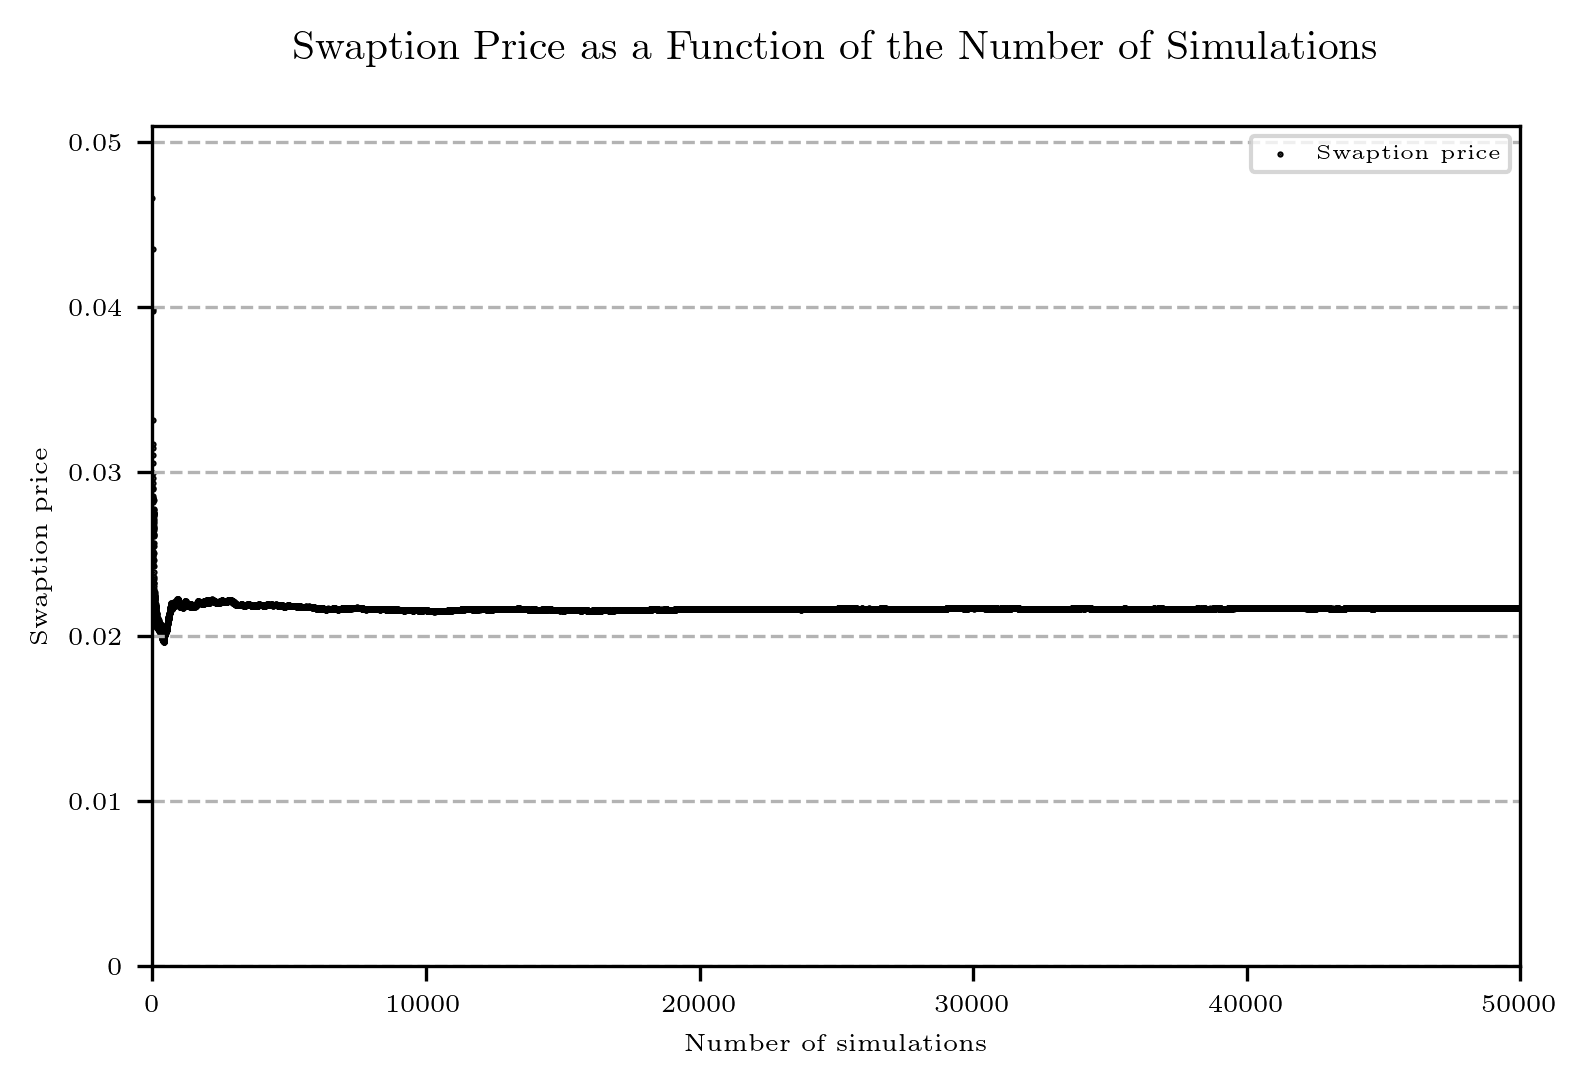

In [37]:
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(6,4))
fig.suptitle(f"Swaption Price as a Function of the Number of Simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul),int((2/5)*N_simul),int((3/5)*N_simul),int((4/5)*N_simul),int(N_simul)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 6)
yticks1 = [0,0.01,0.02,0.03,0.04,0.05]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 6)
p1 = ax.scatter([i for i in range(1,N_simul+1)], price_swaption_plot, s = 1, color = 'black', marker = ".",label="Swaption price")

plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

**IV) Explain how the price of the swaption depends on $\sigma, T_n, T_N$ and of course $K$.**

The price of the swaption will be increasing in $\sigma$ and $T_N$ and decreasing in $T_n$ and $K$.
- higher volatility implies larger uncertainty in future price of the underlying (i.e. the LIBOR rate). This means more probability mass is ITM (although also OTM) in the right hand tail. Meaning more likely to finish ITM and hence call option is more valuable (higher price).
- Time to Expiration: The longer the time to expiration, the greater the probability that the caplet will be exercised, resulting in a higher value.
    - say 10Y swap has a lot of cash flows and thus, so swap with more cash flows will tend to vary more with the parameters in the model. 
- Difference between Strike Rate and Cap Rate: A larger difference between these rates increases the likelihood of the caplet being exercised, leading to a higher value.